# CSC865: Machine Learning Extended Project
## Josh Cowper
### Date: 

# Context
Integration of Machine Learning (ML) practices into the Life Insurance industry can yield significant benefits by leveraging the vast amounts of user data generated by an increasingly digital-native customer-base and data storage improvements (Nadkarni and Prügl, 2020; Maheshwari, 2021). With 95% of all future data growth predicted to be in unstructured formats such as free text, audio or web documents (Gantz and Reinsel, 2012), use of ML tools is critical to future organisational success; revealing insights either currently not available using traditional analytical techniques, or utilising greater complexity in modelling (Adnan and Akbar, 2019; Sarker, 2021).

Within Life Insurers, ML application can support fraud detection, insurance underwriting, experience customisation or new revenue-stream development amongst many potential opportunities (Malhotra and Sharma, 2018). However, at a functional level, ML can also deliver direct benefits to existing teams by automating monotonous, manual tasks. In turn, this enables human resources to prioritise creative, high-value tasks.

This ML project will deliver a Proof of Concept (PoC) using publicly available data to represent automation of a key LifeInsurer process: multi-class classification of free text. Whilst labelled public data (Kaggle, 2021) is based upon Amazon reviews of pet products (Amazon, 2021), this framework will support LifeInsurer to categorise inbound customer queries, messages and call logs to best identify areas of interest, with the aim to better improve customer experience. Furthermore, this will also provide a solution to the existing manual review process, with the predictive model reducing human resource requirements and resultant subjectivity from the task. 

Throughout 2021, LifeInsurer has acquired a significant number of customer responses. Each of which has been manually assigned a topic. To leverage this stored domain knowledge, this PoC will utilise a Supervised Learning approach, using past examples of labelled data to train the model, and inform on future datasets. This will be directly applicable to LifeInsurer, given prevalence of labelled data and ease of access to the organisation.


## Process
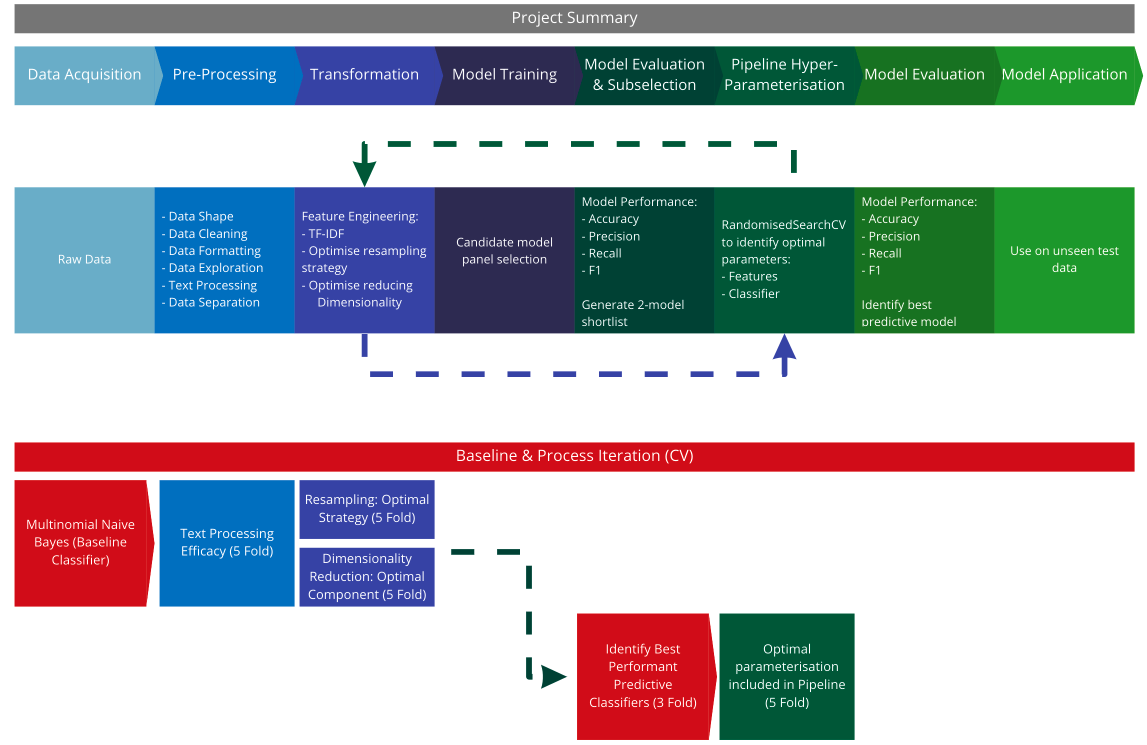
Exploration and iteration throughout this process will ensure that the most effective classification models and resultant parameters are selected. 5 Fold Cross Validation on the Training data will ensure that optimal options are selecting at each iterative stage, including: Feature selection and resampling technique to ensure that the best option is selected. This is further reinforced during hyper-parameterisation when the entire process is wrapped as a pipeline upon which RandomisedSearchCV of hyper-parameters occurs. 







# Project: Multi-Class Text Classification Development



# Acquire and Validate Raw Data

In [1]:
# libraries needed

# standard use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean,stdev
import joblib

# processing
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
import string
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer # snowballstemmer preferred
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
import re
import pprint
import collections

# models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB #best NB for textual data
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# tuning/ pipeline/ evaluation
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline as Pipeline #imblearn pipeline preferred
import time
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize # allows to plot currves for multi-class (using ovevsall approach)
from sklearn.multiclass import OneVsRestClassifier

# resampling
import imblearn
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipe, make_pipeline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jcowper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jcowper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# dataset from github repo
# data files also provided to read in

url1 = 'https://raw.githubusercontent.com/jcowper7newc/multi-class-project/main/data/train.csv'
url3 = 'https://raw.githubusercontent.com/jcowper7newc/multi-class-project/main/data/valid.csv'

# read in as dataframes from kaggle source
train = pd.read_csv(url1)
val = pd.read_csv(url3)

print(train.shape)
print(val.shape)

# concat labelled data
df = pd.concat([train,val])
pd.set_option('display.max_columns',None)

print(df.shape) 
print(df.info())

(52057, 3)
(17353, 3)
(69410, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69410 entries, 0 to 17352
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      69410 non-null  int64 
 1   text    69410 non-null  object
 2   label   69410 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.1+ MB
None


## Raw data interpretation
Provided data is received as two pre-determined train and validation sets. Each contains three columns, row identifier and free text review alongside a class label determining which pet group it belongs to. Furthermore, there are no instances of missing or bad data which need to be addressed at this stage. This results in total data available to the PoC at 69,410 review entries which will support model training, development and validation.

The pre-determined datasets have been combined to provide greater control in creation of a test set to remain unseen. Initial breakdown indicated a 25% ratio of training to test data, whereas author preference is for a smaller test set to maximise minority class vocabularly examples within the training data. Following industry norms, 80% of data will be used for training models, whilst 20% will remain unseen for testing.


# Exploratory Data Analysis and Text Processing


pet labels are..
['dogs' 'cats' 'small animals' 'fish aquatic pets' 'birds'
 'bunny rabbit central']


,Frequency,Proportion %
dogs,37333,53.8
cats,24661,35.5
fish aquatic pets,4789,6.9
birds,1411,2.0
bunny rabbit central,760,1.1
small animals,456,0.7


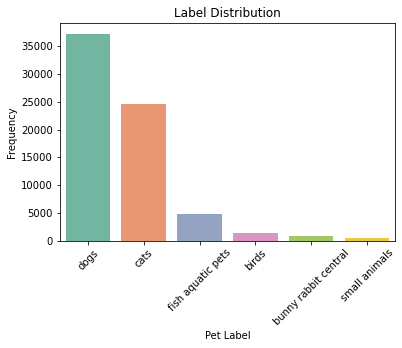

In [4]:
# label distribution
print('pet labels are..')
print(df['label'].unique())

# plot counts
summary = pd.DataFrame(df['label'].value_counts())
# summary['Pet Label'] = df['label'].unique()
summary['Frequency'] = pd.DataFrame(df['label'].value_counts())
summary['Proportion %'] = round(pd.DataFrame(df['label'].value_counts(normalize=True)),3)*100

summary = summary.drop(['label'],axis=1)



g = sns.barplot(x=summary.index.values,y='Frequency',palette = 'Set2',data=summary)
g.set_ylabel('Frequency')
g.set_xlabel('Pet Label')
g.set_title('Label Distribution')
g.despine=True
plt.xticks(rotation=45)


summary


## Label Distribution
The total dataset includes 6 separate classes, however label distribution is clearly imbalanced. 90% of all data is compiled of cat and dog labels despite each class being of equal predictive importance. Furthermore, 3 classes each have under 2% representation.

Label imbalance could influence classifier predictive performance later on, through a bias corpus, limiting examples of minority vocabulary to be used within the TF-IDF process, and over-emphasis on certain labels. In addition, any model classification scoring should account for the likely bias on accuracy metrics due to weightings towards large classes. Classifier investigation should determine the role that resampling has on model performance.

In [3]:
# create a partition to reduce data size whilst in development
df = df.sample(frac=1,replace=False,random_state=10)

In [4]:
# remove unwanted words, characters, punctuation. standardise existing vocab


# pre-processing review text
df = df.rename(columns={'text':'review'})

#df['clean_review'] = df['clean_review'].str.replace('[^\w\s]','')
#df['clean_review'] = df['clean_review'].apply(lambda x: re.sub('[^A-Za-z]',' ',x)) # 2 options

stemmer = SnowballStemmer('english')

def process_text(text):
# lowercase
    text = text.lower()
# special characters
    text = text.replace('[^\w\s]','')
    text = re.sub('[^a-zA-Z]',' ',text)
# tokenise/ punctuation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word.replace('  ',' ') for word in text]
# stopwords
    global stop
    stop = stopwords.words('english')
# stopwords extended following revision (training data seen only)
    stop.extend(['get', 'read','review','recommend', 'also','buy','like', 'one', 'two', 'three', 'good','four', 'five',  'love', 'great', 'would',"i'v",'star','  ','amazon','use','product'])
    text = [word for word in text if word not in stop]
# word stemming
    text = [stemmer.stem(word) for word in text]
# remove single letter words
    text = [word for word in text if len(word)>1]
# join back into review
    text = " ".join(text)
    return text

df['clean_review'] = df['review'].apply(lambda x: process_text(x))




print('Using '+ str(len(stop)) + ' stopwords\n\n')



Using 201 stopwords




,id,review,label,clean_review
38953,38953,My 4 Siamese and 1 oriental all love the cat d...,cats,siames orient cat dancer hide go bed leav alon...
38887,38887,"My 10 pound Cavalier/Bichon mix, Bailey LOVES ...",dogs,pound cavali bichon mix bailey love new booste...
12821,12821,This is much cheaper than a lot of the pet foo...,dogs,much cheaper lot pet food storag market work w...
49573,49573,I can't argue that this doesn't work; it does....,dogs,argu work expect qualiti mat made cheapli flim...
28291,28291,I purchased this crate for my large yellow lab...,dogs,purchas crate larg yellow lab troubl get hous ...


In [8]:
# view all stopwords
#stop

In [309]:
df['orig_review'] = pd.DataFrame(df['review'].apply(lambda x: len(x.split(' '))).astype(int))
df['proc_review'] = pd.DataFrame(df['clean_review'].apply(lambda x: len(x.split(' '))).astype(int))

# full text example of processing
print('Example text processing: \n')
print('Original review:  \n'
+ df.review[38953])

print('\n\nReview following processing:  \n'
+ df.clean_review[38953])
print('\n\n')

#df.loc[df['id'] == 38953]

Example text processing: 

Original review:  
My 4 Siamese and 1 oriental all love the cat dancer i have to hide it when we go to bed they can't leave it and me alone they drag it all about the house following the leader wanting a play with it , when i play with them it drives them crazy they just can't get enough of it .Its money well spent, for a cat lover you will get full enjoyment out if this cat toy


Review following processing:  
siames orient cat dancer hide go bed leav alon drag hous follow leader want play play drive crazi enough money well spent cat lover full enjoy cat toy





In [276]:
# visualise processing impact

# per label category
avg_wc = df.groupby('label').mean().reset_index()
avg_wc= avg_wc[['label','orig_review','proc_review']]
avg_wc = avg_wc.rename(columns={'orig_review':'original review','proc_review':'processed review'})
avg_wc_piv = pd.melt(avg_wc, id_vars=['label'], value_vars=['original review','processed review'])



avg original review words: 84.69851606396773
avg processed review words: 37.09036161936321


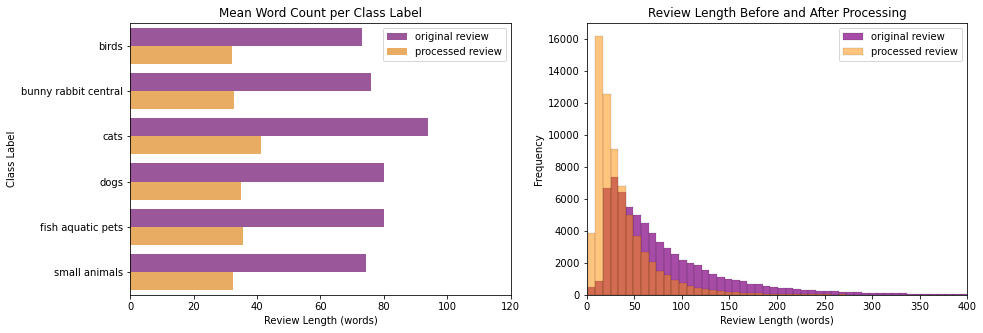

In [310]:
# totals
print('avg original review words: '+str(df['orig_review'].mean()))
print('avg processed review words: '+str(df['proc_review'].mean()))

fig, ax =plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
g = sns.barplot(
    data=avg_wc_piv,  y='label', x='value', hue='variable', alpha=.7,  palette=['purple','darkorange'])
#set_axis_labels('Mean Count','Pet Label')
plt.title('Mean Word Count per Class Label')
plt.legend(loc='best')
plt.xlim(0,120)
plt.xlabel('Review Length (words)')
plt.ylabel('Class Label')

# classifier performance per component set
plt.subplot(1, 2, 2) # index 2
g = sns.histplot(df['orig_review'],binwidth=8,color='purple',alpha=0.7,legend=False)
g = sns.histplot(df['proc_review'],binwidth=8,alpha=0.5,color='darkorange',legend=False)
#fig.legend(labels=['original','processed'])
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.title('Review Length Before and After Processing')
plt.xlim(0,400)
plt.legend(labels=['original review','processed review'],loc='best')




Text(0, 0.5, 'Review Length (words)')

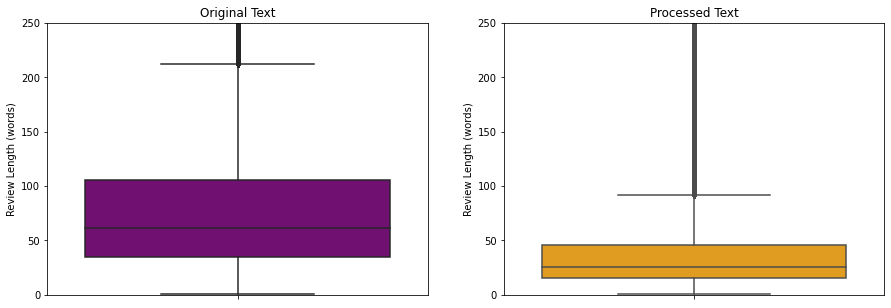

In [296]:
# review length distribution
fig, ax =plt.subplots(1,2,figsize=(15,5))
sns.boxplot(y='orig_review',data=df,ax=ax[0],color='purple',)
sns.boxplot(y='proc_review',data=df,ax=ax[1],color='orange')
ax[0].set_ylim(0,250) 
ax[1].set_ylim(0,250) 
ax[1].set_title('Processed Text')
ax[0].set_title('Original Text')
ax[0].set_ylabel('Review Length (words)')
ax[1].set_ylabel('Review Length (words)')






Text(0.5, 1.0, 'WordCloud amongst Clean Corpus')

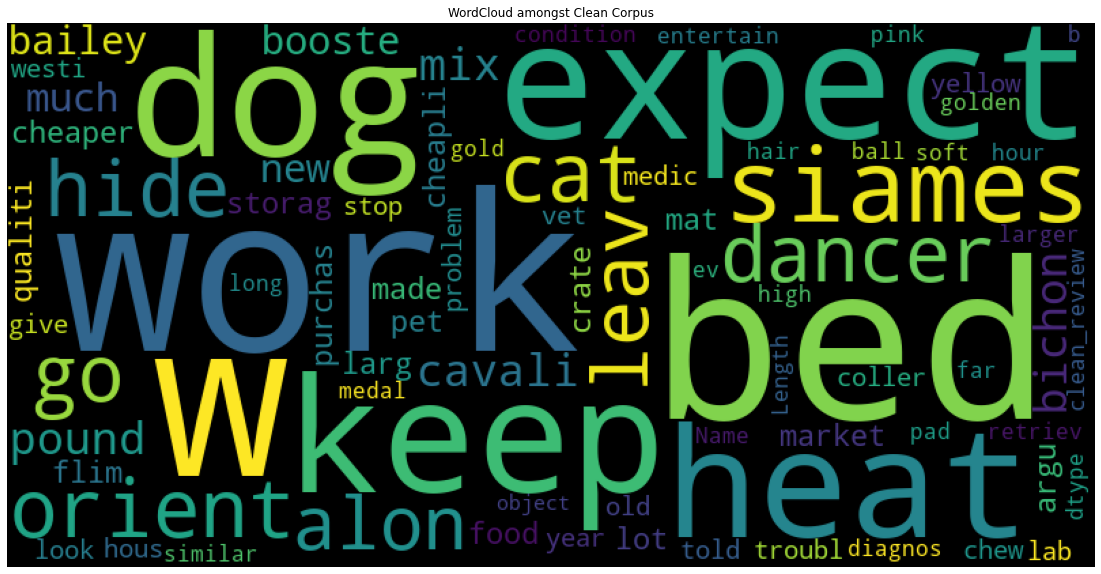

In [145]:
# wordcloud to visualise new clean_review corpus
clean_corpus = []
for word in df['clean_review'].str.split(' '):
  clean_corpus.extend(word)


wordcloud = WordCloud(random_state=10,width=800,height=400,stopwords=stop).generate(str(df['clean_review']))
plt.figure( figsize=(20,10) )

plt.imshow(wordcloud)
plt.axis('off')
plt.title('WordCloud amongst Clean Corpus')



In [146]:
# top words in corpus (all classes)
ct = collections.Counter(clean_corpus)
most_freq = pd.DataFrame(ct.most_common(10))
most_freq = most_freq.rename(columns={0:'Word',1:'Frequency'})
most_freq

,Word,Frequency
0,dog,53722
1,cat,37057
2,work,23163
3,use,17755
4,time,17717
5,toy,15382
6,well,14843
7,tri,13174
8,day,12320
9,litter,12154


## Text Processing Interpretation
Text Processing has clearly impacted the initial review structure and format. Besides the removal of Punctuation and numbers, all text is now lowercase. The benefit of which is the removal of excessive vocabulary to be stored within the word corpus and the reduction of likely vocabularly redundancy. For example, 'Cat' and 'cat' could be stored as distinct words, despite identical meaning. Word stemming also targets vocabularly redundancy through normalisation by reducing words to the intial stem which affixes prefix and suffix forms of each word. In addition, a total of 201 non-important words, termed stopwords have been excluded. These include common words which in the context of modelling convey no real meaning. For example, this could include 'the' or 'and'. 

Combined, this results in mean review length reducing by 44%; reducing from 85 to 37 per review. Distribution of review length per label class remains consistent, indicating that most reviews, regardless of class contain approximately the same level of information, in which to identify a classifier. The expected challenge will mainly focus upon the smaller number of documents available for those classes which are under-represented.

Furthermore, although only heuristic, the wordcloud visualisation quickly illustrates inclusion of relevant words. Class-specific examples such as pet breeds such as 'dog','cat','cavalier' or 'siamese' feature alongside more general pet terms like 'bed','toy' or 'litter'. Class-specific words will be investigated in more detail below.

A reduced corpus vocabulary should improve model classification performance due to reduced features and resultant complexity. However, this will be validated later within the process (Previous words have included 'amazon','buy' or 'review', which is not surprising given the data source - amazon reviews).

## Data Separation: Train and Test
Creation of a Train and Test set provides a labelled set of data upon which a final predictive model can be compared. Performance of a predictive model which has used 'training' data indicates how well this model can generalise to new, external data which will be found in the 'real-world' situations.

Critically, the full dataset must be split at this early stage to avoid undue data leakage from test data influencing the necessary iteration and improvement of features and model. Test leakage would result in over-optimistic final analysis upon the test data. 

Within the Text Processing stage,  this will ensure that test vocabularly does not feature within updated stopword list iterations. However, this is an equally important step for later model refinement and development as potential features and classifiers are assessed on their performance attributes.



In [313]:
# splitting data and preparing for modelling for initial testing
# turn categorical label to number
LE = LabelEncoder()
df['label_num'] = LE.fit_transform(df['label'])
#display(df.groupby(['label'])['label'].count())
#display(df.groupby(['label_num'])['label'].count())

# label allocation
#print(df['label'].unique())
#print(df['label_num'].unique())

label_dict ={'cats':2,'dogs':3,'birds':0,'bunny rabbit central':1,'fish aquatic pets':4,'small animals':5}


print('Labels encoded within dictionary as numeric: ')
label_to_num = pprint.pprint(label_dict)


Labels encoded within dictionary as numeric: 
{'birds': 0,
 'bunny rabbit central': 1,
 'cats': 2,
 'dogs': 3,
 'fish aquatic pets': 4,
 'small animals': 5}


In [7]:
X = df[['label','clean_review','review']] # label to be removed pre-modelling
y = df['label_num'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True,stratify=y, random_state=10)


# confirming stratified split
lab = ['Dog','Cat','Fish','Birds','Bunny','Small Animals']
split = pd.DataFrame([lab,pd.value_counts(df['label_num'],normalize=True),pd.value_counts(y_train,normalize=False),pd.value_counts(y_test,normalize=False)]).T
split = split.rename(columns={0:'Class Label',1:'Original Distribution %',2:'Train Size',3:'Test Size'})
print('Validation Size')

print('Training:' + str(X_train.shape) +'\nTesting: '+str( X_test.shape)+'\n\nStratified Label Distribution %:')
split

# stratifying the split at this stage will allow to test any impact
# that resampling training data has on test performance by providing a baseline



Validation Size
Training:(55528, 3)
Testing: (13882, 3)

Stratified Label Distribution %:


,Class Label,Original Distribution %,Train Size,Test Size
0,Dog,0.537862,29866,7467
1,Cat,0.355295,19729,4932
2,Fish,0.068996,3831,958
3,Birds,0.020328,1129,282
4,Bunny,0.010949,608,152
5,Small Animals,0.00657,365,91


Each categorical Class can now be represented with a number. A Dictionary ensures that these can be related back for final class-level analysis within each Train and Test dataset.

Critically, split stratification ensures that there is equal representation found within the original dataset for each class as the new training and testing sets.

## Class-level Vocabularly Exploration
Review content can be explored by investigating ngram frequency. Unigrams count individual words, whereas bigrams count the two words adjacent within a review.

These can yield significant information for the processing process. For example, revealing stopwords missed initially, or interesting combinations. Furthermore, processed text will form the features used by predictive models, therefore, both unigrams, bigrams or both might be considered for use by the predictive classifier. 

In [174]:
# Class level vocabulary exploratory investigation

# top 10 words per label (train data)
df_cat = X_train.loc[X_train['label']=='cats']
df_dog = X_train.loc[X_train['label']=='dogs']
df_bird = X_train.loc[X_train['label']=='birds']
df_bunny = X_train.loc[X_train['label']=='bunny rabbit central']
df_fish = X_train.loc[X_train['label']=='fish aquatic pets']
df_small = X_train.loc[X_train['label']=='small animals']


# ngram (1,1) exploration
def most_common(df,df2,topn):
  list = []
  name = df2.values[0]
  for word in df.str.split(' '):
    list.extend(word)
  ct = collections.Counter(list)
  sub_df = pd.DataFrame(ct.most_common(topn))
  sub_df = sub_df.rename(columns={0:name,1:'Freq'})

  return(sub_df)

cat = most_common(df_cat['clean_review'],df_cat['label'],10)
dog = most_common(df_dog['clean_review'],df_dog['label'],10)
bird = most_common(df_bird['clean_review'],df_bird['label'],10)
fish = most_common(df_fish['clean_review'],df_fish['label'],10)
bun = most_common(df_bunny['clean_review'],df_bunny['label'],10)
sml = most_common(df_small['clean_review'],df_small['label'],10)

label_word_freq = pd.concat([cat,dog,bird,fish,bun,sml],axis=1)
label_word_freq



    

,cats,Freq,dogs,Freq,birds,Freq,fish aquatic pets,Freq,bunny rabbit central,Freq,small animals,Freq
0,cat,26113,dog,35709,bird,943,tank,3227,cage,360,cage,317
1,litter,9514,work,9346,cage,776,filter,2664,rabbit,263,food,207
2,box,8281,toy,9131,perch,293,water,2071,pig,196,hamster,141
3,work,7528,time,7096,food,280,fish,2000,guinea,181,rat,120
4,dog,7229,collar,6679,time,237,work,1426,hay,175,pig,107
5,use,6511,use,6513,toy,228,gallon,1035,bunni,160,ferret,105
6,time,5825,well,6226,seed,215,use,968,bed,158,guinea,93
7,clean,4890,love,5636,well,213,aquarium,960,time,127,rabbit,92
8,well,4598,tri,5401,water,207,clean,771,small,125,clean,81
9,tri,4533,littl,4937,love,201,time,769,love,122,eat,73


In [25]:
# ngram(2,2) exploration - bigrams

def bigram_common(df1,df2 ,top_n):
    ct_vec = CountVectorizer(ngram_range=(2,2))
    list = []
    name = df2.values[0] # for df col name
    bigrams = ct_vec.fit_transform(df1) # matrix of bigrams
    count_word = bigrams.toarray().sum(axis=0) # count freq bigrams
    vocab = ct_vec.vocabulary_ # list of bigrams
    
    bigram_df = pd.DataFrame([(k,count_word[i]) for k,i in vocab.items()]
                            ).sort_values(by=1,ascending=False).rename(columns={0:name,1:'Freq'}).reset_index(drop=True) 
    
    bigram_df = bigram_df.head(10)

    return bigram_df#.head(top_n)


cat_bi = bigram_common(df_cat['clean_review'],df_cat['label'],10)
dog_bi = bigram_common(df_dog['clean_review'],df_dog['label'],10)
bird_bi = bigram_common(df_bird['clean_review'],df_bird['label'],10)
fish_bi = bigram_common(df_fish['clean_review'],df_fish['label'],10)
bun_bi = bigram_common(df_bunny['clean_review'],df_bunny['label'],10)
sml_bi = bigram_common(df_small['clean_review'],df_small['label'],10)


label_bigram = pd.concat([cat_bi,dog_bi,bird_bi,fish_bi,bun_bi,sml_bi],axis=1)

label_bigram


,cats,Freq,dogs,Freq,birds,Freq,fish aquatic pets,Freq,bunny rabbit central,Freq,small animals,Freq
0,litter box,1795,year old,750,put togeth,37,gallon tank,181,guinea pig,102,guinea pig,48
1,work well,510,dog love,628,pet store,27,fish tank,125,easi clean,15,pet store,14
2,year old,443,work well,577,african grey,26,water chang,122,small anim,14,water bottl,13
3,cat love,401,month old,479,bird feeder,18,work well,84,pet store,10,timothi hay,9
4,everi day,370,dog food,456,work well,17,air pump,69,dwarf rabbit,8,easi clean,8
5,cat litter,316,small dog,432,everi day,17,make sure,61,water bottl,8,ferret food,8
6,clean litter,268,dog toy,325,sun conur,17,suction cup,61,work well,8,bought cage,6
7,make sure,261,well made,322,small bird,16,canist filter,59,timothi hay,8,rat food,6
8,cat food,248,pet store,298,easi clean,16,pet store,58,last week,8,litter box,6
9,cat box,222,larg dog,278,bird food,14,crystal clear,56,wood shave,7,clean cage,6


## Exploration Interpretation
Unigrams indicate that for each class, vocabularly appears relevant. In particular, vocabularly for Bird and Fish Classes are very distinct compared to other Pet Classes. This is not surprising given the unique habitat fish have in comparison to other Classes. However, there are some cross-class inclusions. For example, there are 3,809 instances of 'dog' within the Cat Class. This could be because they share the same pet niche, or product owners are perhaps likely to own multiple pets, given a speciifc pet owned. Moreover, there is significant cross-over between 'bunny' and 'small animals', although expected given the overlap in animals each Class contains. Without domain knowledge assumptions can be made, but further interrogation of label allocation and reviewer source can enhance knowledge of these relationships. For the purposes of this PoC, further investigation is limited, however expanded to real-world settings at LifeInsurer, this would be pursued.

Bigrams indicate that litter is a common priority for Cat owners whereas Dog owners are more focussed upon food and play. Again, Bird and Fish retain unique popular vocabularly, whilst Bunny and Small Animals have similar vocabularies, although some rabbit specific vocabularly is more prominent within Bunny, such as breeds ' Dwarf'. Small Class sizes for these two groups is also not beneficial, limiting vocabularly options further; reducing possible differentiators between classes.

Both Unigrams and Bigrams appear useful. The best options shall be considered for use within the final classifier model during hyper-parameterisation.

# Feature Generation and TF-IDF
Feature Extraction is required to transform the textual language data contained within each review into features which can be interpreted by classification algorithms. A common approach used is the Bag-of-Words (BOW) model, which transforms each unique word from the total vocabularly into features, with the count of occurences recorded. However, this can over-emphasise words which are more frequent in general use. TF-IDF addresses this. Instead of frequency, TF-IDF increases proportionally to the relative frequency of a term within each document. As a result, 83% of text-based reccomender systems in use now use TF-IDF (Breitinger, Gipp & Langer, 2015). 
### https://link.springer.com/article/10.1007/s00799-015-0156-0



In [8]:
# feature text
# preparing clean review and original review datasets to investigate if a cleaned corpus improves classifier predictive performance
# drop label from feature modelling (only focussed on review bodies)

#X_train = X_train.drop('label',axis=1)
#X_test = X_test.drop('label',axis=1)

#train
orig_review_train = X_train['review'].astype(str) # test to see if pre-processing improves baseline
clean_review_train = X_train['clean_review'].astype(str)

# test
orig_review_test = X_test['review'].astype(str)
clean_review_test = X_test['clean_review'].astype(str)






In [45]:
# optimising at Pipeline stage, currently using defaults
# 2 vectoriser per corpus. Will pass vocab from training set as parameter to test data

# original review text
tf_idf_orig_1 = TfidfVectorizer()

tf_idf_clean_1 = TfidfVectorizer()

# features to use for training set
X_train_clean = tf_idf_clean_1.fit_transform(clean_review_train)
X_train_orig = tf_idf_orig_1.fit_transform(orig_review_train)
y_train

print('Training Corpus Feature Generation:')
print('TF-IDF Features generated:  '+ str(X_train_orig.shape[1])+' as standard pre-optimisation (original text)')
print('TF-IDF Features generated:  '+ str(X_train_clean.shape[1])+' as standard pre-optimisation (processed text)')


# applying training corpus to validation set
tf_idf_orig_2 = TfidfVectorizer(vocabulary=tf_idf_orig_1.vocabulary_)
tf_idf_clean_2 = TfidfVectorizer(vocabulary=tf_idf_clean_1.vocabulary_)

X_test_orig = tf_idf_orig_2.fit_transform(orig_review_test)
X_test_clean = tf_idf_clean_2.fit_transform(clean_review_test)

X_train_clean.shape

Training Corpus Feature Generation:
TF-IDF Features generated:  42883 as standard pre-optimisation (original text)
TF-IDF Features generated:  27164 as standard pre-optimisation (processed text)


(55528, 27164)

## Model Baseline and Text Processing Efficacy using Naive Bayes
To establish the benefit of text processing, a baseline exercise will be conducted to assess performance. Multinomial Naive Bayes is a suitable candidate classifier given lack of assumptions, efficiency and fast execution. 

Performance will be assessed using 5 fold Cross Validation. Whilst total accuracy will be provided, class accuracy is more informative. Imbalanced class distribution over-scores true accuracy due to the increased likelihood of guessing the most common class. The best performing feature-set, either on processed or raw data, will be used further in the development of the PoC.


In [17]:
# MultinomialNB baseline (no tuning)
# K5 CV (istead of train-test)
NB = MultinomialNB()
skf=StratifiedKFold(n_splits=5, shuffle=True,random_state=10)


# confirming that default behaviour for cross_val_score uses a stratified CV split

# manual stratified fold
nb_skf_acc = []
for train_ind, test_ind in skf.split(X_train_orig, y_train):
  x_train_fold, x_test_fold = X_train_orig[train_ind], X_train_orig[test_ind]
  y_train_fold, y_test_fold = y_train[train_ind],y_train[test_ind]
  NB.fit(x_train_fold,y_train_fold)
  nb_skf_acc.append(NB.score(x_test_fold,y_test_fold))

# default cross_val_score stratification score/ when specifying cv type
nb_orig_score = cross_val_score(NB,X_train_orig,y_train,cv=10,scoring='accuracy')
nb_orig_skf_score = cross_val_score(NB,X_train_orig,y_train,cv=skf,scoring='accuracy')

# CV outputs (orig text test)
print('cross val score default: ', nb_orig_score.mean())
print('manual skf score: ', mean(nb_skf_acc))
print('cross val score with skf: ',nb_orig_skf_score.mean())



print('\n')
print('5 Fold Accuracy for Original Text: ', nb_orig_skf_score.mean())
y_pred = cross_val_predict(NB, X_train_orig,y_train,cv=skf)
matrix = confusion_matrix(y_train,y_pred)

print('Class Accuracy: ',(matrix.diagonal()/matrix.sum(axis=1)).round(3))
nb_clean_skf_score = cross_val_score(NB,X_train_clean,y_train,cv=skf,scoring='accuracy')
nb_clean_skf_f1 = cross_val_score(NB,X_train_clean,y_train,cv=skf,scoring='f1_macro')

print('\n5 Fold Accuracy for Cleaned Text: ', nb_clean_skf_score.mean())
print('5 Fold F1 for Cleaned Text: ', nb_clean_skf_f1.mean())

y_pred = cross_val_predict(NB, X_train_clean,y_train,cv=skf)
matrix = confusion_matrix(y_train,y_pred)
print('Class Accuracy: ',(matrix.diagonal()/matrix.sum(axis=1)).round(3))


# cleaned text provides better accuracy
# further predictor information 
print('\n\nClean, Processed Text: Classification Report')
print(matrix)
print(classification_report(y_train,y_pred))





cross val score default:  0.7388884283023793
manual skf score:  0.7321170517366399
cross val score with skf:  0.7321170517366399


5 Fold Accuracy for Original Text:  0.7321170517366399
Class Accuracy:  [0.001 0.    0.576 0.96  0.156 0.   ]

5 Fold Accuracy for Cleaned Text:  0.7631823905092695
5 Fold F1 for Cleaned Text:  0.35621462787027325
Class Accuracy:  [0.014 0.    0.641 0.943 0.404 0.   ]


Clean, Processed Text: Classification Report
[[   16     0   399   710     4     0]
 [    0     0    77   531     0     0]
 [    0     0 12640  7074    15     0]
 [    1     0  1673 28176    16     0]
 [    0     0  1211  1074  1546     0]
 [    0     1    59   304     1     0]]
              precision    recall  f1-score   support

           0       0.94      0.01      0.03      1129
           1       0.00      0.00      0.00       608
           2       0.79      0.64      0.71     19729
           3       0.74      0.94      0.83     29866
           4       0.98      0.40      0.57    

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### NB Baseline Classification Interpretation:
Classification accuracy for the baseline is strong at 73% without text pre-processing. However, text processing improves accuracy score to 76% despite including 15,719 fewer features, suggesting that improved feature parsimony enhances model performance. 

However, both of these approaches high accuracy scores are likely due to the label over-representation in Class of Cat and Dog, which is highlighted by the 0.35 F1 score, a harmonious metric of Precision and Recall ability. Interrogating Class accuracy scores reveal significant improvements in minority class classification following text processing. In particular, Fish (Class 4) has increased from 16% to 40% classification. Bunny Class (1) remains poorly classified regardless of text processing. Further model development will utilise the clean, processed text corpus.

Further analysis of the clean, processed text provides additional performance metrics. High Precision for minority classes indicates that class prediction occurs only the most obvious cases, with minimal false positives. Recall in contrast scores very poorly resulting from high false negatives due to over-prediction on majority classes. This is reflected in the the weighted metric, F1 which combines outcomes from both Precision and Recall. In contrast, over-prediction to majority classes, enhances Recall to the detriment of Precision. 

Resampling the training data could improve model performance by rebalancing label distribution and therefore better classification of minority classes. Different methodologies will be assessed. 

# Resampling
Three Resampling techniques will be used to adjust class label distribution with the aim of balancing model training to respect each label equally, and therefore predictive ability. Increase in representation of minority classes will be prioritised with two oversampling approaches due to small sample availability. A manual over and undersampling approach will also be used across all classes to assess impact of a smaller training dataset. If this is viable it could offer significant performance benefits due to the reduced dimensionality and ongoing processing needed.

Oversampling Strategies:
- SMOTE
- ROS (Random Over Sampler)
- Manual Resampling (over and undersampling)

In [324]:
# BEST RESAMPLING TECHNIQUE - 5k CV
# SMOTE, ROS or undersample


# clean text
skf=StratifiedKFold(n_splits=5, shuffle=True,random_state=10) # reducing CV to 5 due to oversampling size



# SMOTE
smt = SMOTE(random_state=10,sampling_strategy='not majority') # oversamples minority classes
smt_x_clean, smt_train_y = smt.fit_resample(X_train_clean,y_train)
#print('SMOTE Resampled Label distribution:\n',pd.value_counts(smt_train_y))

smt_acc = cross_val_score(NB, smt_x_clean, smt_train_y,cv=skf,scoring='accuracy')
smt_f1 = cross_val_score(NB, smt_x_clean, smt_train_y,cv=skf,scoring='f1_macro')

smt_pred = cross_val_predict(NB,smt_x_clean,smt_train_y,cv=skf)
#print('\nSMOTE Accuracy: ',smt_acc.mean())
#print('SMOTE F1: ',smt_f1.mean())
smt_matrix = confusion_matrix(smt_train_y,smt_pred)
#print('Class Acc: ',smt_matrix.diagonal()/smt_matrix.sum(axis=1))

#print(classification_report(smt_train_y,smt_pred))



# Random Over Sampling

ros = RandomOverSampler(random_state=10,sampling_strategy='not majority')
ros_x_clean, ros_train_y = ros.fit_resample(X_train_clean,y_train)
#print('\nROS Resampled Label distribution:\n',pd.value_counts(ros_train_y))

ros_acc = cross_val_score(NB, ros_x_clean, ros_train_y,cv=skf,scoring='accuracy')
ros_f1 = cross_val_score(NB, ros_x_clean, ros_train_y,cv=skf,scoring='f1_macro')

ros_pred = cross_val_predict(NB,ros_x_clean,ros_train_y,cv=skf)
#print('\nROS Accuracy: ',ros_acc.mean())
#print('ROS F1: ',ros_f1.mean())
ros_matrix = confusion_matrix(ros_train_y,ros_pred)
#print('Class Acc: ',ros_matrix.diagonal()/ros_matrix.sum(axis=1))

#print(classification_report(ros_train_y,ros_pred))





# Random resampling: Manual Over/ Under

resample_n= 2000 # random over/ undersamples all classes to 2000 docs
#print('\n')

re_dog = df_dog.sample(resample_n)
re_cat = df_cat.sample(resample_n,replace=True)
re_fish = df_fish.sample(resample_n,replace=True)
re_birds = df_bird.sample(resample_n,replace=True)
re_sml = df_small.sample(resample_n,replace=True)
re_bun = df_bunny.sample(resample_n,replace=True)


resample = pd.concat([re_dog,re_cat,re_fish,re_birds,re_sml,re_bun])

resample['label'].value_counts()

X_train_clean_review = resample['clean_review'].astype(str)
resample_tfidf = resample['clean_review'].astype(str)
resample_tfidf = tf_idf_clean_2.fit_transform(resample_tfidf)
resample_tfidf # n 55524 (9254 * 6) # observe performance and can increase if possible

# Resplitting resampled data and prepare for modelling
LE = LabelEncoder()
resample['label_num'] = LE.fit_transform(resample['label'])

X_train_re = resample_tfidf
y_train_re = resample['label_num'].values
X_train_re #55524 x 30928


# improvement vs B baseline?
#print('Resample to equal values per K: ' ,resample_n) 
#print('Manual Resample Label distribution:\n',pd.value_counts(y_train_re))

acc = cross_val_score(NB, X_train_re, y_train_re,cv=skf,scoring='accuracy')
f1 = cross_val_score(NB, X_train_re, y_train_re,cv=skf,scoring='f1_macro')


pred = cross_val_predict(NB,X_train_re, y_train_re,cv=skf)
#print('\nManual Resample Accuracy: ',acc.mean())
#print('Manual Resample F1: ',f1.mean())
matrix = confusion_matrix(y_train_re,pred)
#print('Class Acc: ',matrix.diagonal()/matrix.sum(axis=1))

#print(classification_report(y_train_re,pred))


In [322]:
# Resample class sizes
X_train['label_nu'] = LE.fit_transform(X_train['label'])
lab = ['Dogs','Cats','Fish','Birds','Bunny','Small Animals']

resample_option_df = pd.DataFrame(
                        [lab,X_train['label_nu'].value_counts(),
                                pd.value_counts(smt_train_y),
                                   pd.value_counts(ros_train_y),
                                  resample['label_num'].value_counts()
                                   
]).T
resample_option_df = resample_option_df.rename(columns={0:'Class Label',1:'Original',2:'SMOTE',3:'ROS',4:'Manual Resample'})


print('Resample Class sizes')
resample_option_df = resample_option_df#.sort_values(by='Original',ascending=False)


resample_option_df




Resample Class sizes


/var/folders/3b/s2_qr8851w7g2dw_4h78nd380000gn/T/ipykernel_29776/4014071618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['label_nu'] = LE.fit_transform(X_train['label'])


,Class Label,Original,SMOTE,ROS,Manual Resample
0,Dogs,29866,29866,29866,2000
1,Cats,19729,29866,29866,2000
2,Fish,3831,29866,29866,2000
3,Birds,1129,29866,29866,2000
4,Bunny,608,29866,29866,2000
5,Small Animals,365,29866,29866,2000


In [325]:
# overall resampling scores
score = ['accuracy','precision_macro','recall_macro','f1_macro']
smt_score = cross_validate(NB,smt_x_clean,smt_train_y, cv=skf, scoring = score)
ros_score = cross_validate(NB,ros_x_clean,ros_train_y, cv=skf, scoring = score)
manual_score = cross_validate(NB,X_train_re,y_train_re, cv=skf, scoring = score)
original_score = cross_validate(NB,X_train_clean,y_train, cv=skf, scoring = score)

resample_dict = {'Original':original_score,'SMOTE':smt_score,'ROS':ros_score,'Manual Resample':manual_score}

def best_resample(resdict):
  name,acc,prec,rec,f1 = [],[],[],[],[]
  for n, p in resdict.items():
    name.append(n)
    acc.append(p['test_accuracy'].mean())
    prec.append(p['test_precision_macro'].mean())
    rec.append(p['test_recall_macro'].mean())
    f1.append(p['test_f1_macro'].mean())
    df = pd.DataFrame([name,acc,prec,rec,f1]).T
    df = df.rename(columns={0:'Resample Method',1:'Accuracy',2:'Precision',3:'Recall',4:'F1'})


  return df

resample_df = best_resample(resample_dict)

resample_df.sort_values(by=['F1'],ascending=False)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedM

,Resample Method,Accuracy,Precision,Recall,F1
1,SMOTE,0.907386,0.906183,0.907386,0.906655
2,ROS,0.893614,0.892657,0.893614,0.89297
3,Manual Resample,0.85125,0.851412,0.85125,0.850711
0,Original,0.763182,0.576353,0.333635,0.356215


In [318]:
# SMOTE scored highest scores. See classification report for additional info
# more SMOTE details
print('SMOTE resampling technique scored highest Accuracy and F1\nSMOTE Accuracy: ',smt_acc.mean())
print('\nFurther details:')
print(classification_report(smt_train_y,smt_pred))

SMOTE resampling technique scored highest Accuracy and F1
SMOTE Accuracy:  0.9073863202509337

Further details:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     29866
           1       0.94      0.96      0.95     29866
           2       0.82      0.78      0.80     29866
           3       0.82      0.81      0.81     29866
           4       0.97      0.97      0.97     29866
           5       0.95      0.97      0.96     29866

    accuracy                           0.91    179196
   macro avg       0.91      0.91      0.91    179196
weighted avg       0.91      0.91      0.91    179196



## Resampling Technique Interpretation
SMOTE delivers the highest scores in both Accuracy and F1, with mean Classification accuracy of 91% from 5-fold Cross Validation. Performance is 1% better in contrast to ROS, and 5% better than undersampling majority classes. 0.91 F1 (increasing from 0.35) indicates that predictive false positives and false negatives have reduced, and classification is much more effective across all classes.

In comparison to the two alternative techniques, ROS and manual undersampling attempts. SMOTE synthesises new examples of each minority classes based on 5 nearest class neighbours within pre-existing documents, improving in-class variety and feature relationships. Furthermore, artificial examples may help to mitigate the effects of overfitting which are likely to occur, given the vast oversampling occurring (for example, Small Animals (5) has increased by a ratio of 81 times, from 365 to 29866, a vast oversampling ratio.

SMOTE oversampling will be used as the resampling technique of choice for model prediction. However, outside of PoC when using LifeInsurer customer data, suitability of sampling strategy must be assessed to mitigate high dimensionaliy issues.






# NEED TO UPDATE Feature Reduction
- Identify optimal feature reduction using Latent Semantic Analysis (Truncated SVD) to condense corpus features
- SVD is a good option due to optimisation to reduce sparse matrices such as that produced by TF-IDF
- Do now to avoid very performance intensive process within wider pipeline parameterisation. 


In [320]:
# renaming for ease

X_train_re = smt_x_clean
y_train_re = smt_train_y

X_test = X_test_clean
y_test.shape


print(X_train_re.shape,y_train_re.shape) # X_train oversampled with SMOTE (179k rows, 27k features) and y_train (OVERSAMPLED)
print(X_test.shape,y_test.shape) # test data


(179196, 27164) (179196,)
(13882, 27164) (13882,)


In [ ]:
# target component range
comps = [1,10,100,200,300,400,500]
import time
# measure component classifier performance
def best_component(comps, xtrain,ytrain):
    comp, var,gen,acc, f1 = [],[],[],[],[]
    for c in comps:
        start = time.time()
        # labelling info
        svd = TruncatedSVD(n_components=c, random_state=10,n_iter=10)
        svd.fit(xtrain)
        comp.append(c)
        v = svd.explained_variance_ratio_.sum()
        var.append(v)

        # transform for preds
        xtra = svd.fit_transform(xtrain)
        scale = MinMaxScaler()
        xtra = scale.fit_transform(xtra)
        end = time.time()
        tot = end-start


        # predictions
        mb = MultinomialNB()
        acc_score = cross_val_score(mb, xtra,ytrain,cv=skf,scoring='accuracy').mean()
        f1_score = cross_val_score(mb, xtra,ytrain,cv=skf,scoring='f1_macro').mean()
        acc.append(acc_score)
        f1.append(f1_score)
        gen.append(tot)
        # join
        df = pd.DataFrame([comp,var,acc,f1,gen]).T
        df = df.rename(columns={0:' n Components',1:'Cum Var',2:'Accuracy',3:'F1',4:'Generation time (s)'})
        
    return df
        
component_df = best_component(comps,X_train_re,y_train_re)       

component_df

,n Components,Cum Var,Accuracy,F1,Generation time (s)
0,1.0,0.019529,0.166661,0.047618,6.111841
1,10.0,0.132707,0.563696,0.589110,9.402272
2,100.0,0.334195,0.714737,0.719232,52.416790
3,200.0,0.435367,0.727070,0.732274,98.986223
4,300.0,0.506295,0.737784,0.742977,136.791440
5,400.0,0.560582,0.743778,0.748915,186.495603
6,500.0,0.604532,0.747667,0.752767,248.889041


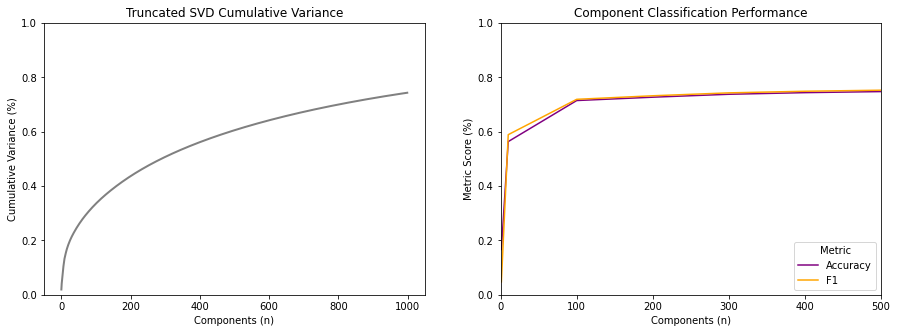

In [ ]:
# Visualising SVD dim reduction accuracy
x = [1,10,100,200,300,400,500]
svd = TruncatedSVD(n_components=1000, random_state=10,n_iter=10)
svd.fit_transform(X_train_re) # fit to train


# component variance proportion, 
fig, ax =plt.subplots(1,2,figsize=(15,5))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.ylim(0,1)
plt.plot(np.cumsum(svd.explained_variance_ratio_),color='grey',lw=2)
plt.title('Truncated SVD Cumulative Variance')
plt.xlabel('Components (n)')
plt.ylabel('Cumulative Variance (%)')

# classifier performance per component set
plt.subplot(1, 2, 2) # index 2
plt.xlim(0,500)
plt.ylim(0,1)
x = [1,10,100,200,300,400,500]
plt.plot(x,component_df['Accuracy'], color='purple')
plt.plot(x,component_df['F1'], color='orange')
plt.title('Component Classification Performance')
plt.legend(['Accuracy','F1'],loc='lower right',title='Metric')
plt.xlabel('Components (n)')
plt.ylabel('Metric Score (%)')
plt.show()

## Feature Reduction Optimal Components
### 100 components is a good compromise between performance and accuracy
Classifier Performance plateaus at 75% accuracy and 75% F1, with limited benefits gained by increasing component number above 100, despite 100 components only accounting for 33% of total variance.

Reduced dimensionality not retains all original (27k) corpus TF-IDF scores, but will also support better classification modelling by increasing model parsimony; promoting more effective predictive abilty. 

Furthermore, by limiting features to 100, computational requirements for data transformation are limited, better supporting user investigation and analysis.


In [321]:
# feature reduction of data to 100 for train and test
svd = TruncatedSVD(n_components=100, random_state=10,n_iter=10)
svd.fit_transform(X_train_re) # fit to train

X_train_re_red = svd.fit_transform(X_train_re)
X_test_red = svd.transform(X_test) # use train parameters on test (test remains unseen)
scaler = MinMaxScaler() # need to scale for NB use (cannot be negative)
X_train_re_red = scaler.fit_transform(X_train_re_red)
X_test_red = scaler.transform(X_test_red) #use train parameters on test (test remains unseen)

print('Training and Testing Data X shape: ')
X_train_re_red.shape, X_test_red.shape

Training and Testing Data X shape: 


((179196, 100), (13882, 100))

# Model Development and Evaluation (Training Data)
Training data oversampled and reduced using SMOTE and LSA reduction each individually improve model performance using the baseline classifier Naive Bayes. However, other predictive models could be more effective at classification. Development of a model suite will ensure that the best candidate classifiers are selected for further tuning and evaluation. 3-Fold cross validation of the training data will be used to calculcate performance metrics; managing the relationship between computational resource and mean metric convergence to form conclusions.

Model selection is crucial to achieving optimal predictions from datasets, therefore a mixture of linear and non-linear classifiers have been included, each from different families, with different strengths and weaknesses. No instances of Neural Networks have been included at this stage to best represent the resources and access which LifeInsurer would be able to use following PoC release. For the purposes of the PoC traditional supervised models will be used only.

Initial model comparison and selection will be comprised of:

   - Naive Bayes
   - Logistic Regression
   - Stochastic Gradient Descent Regressor
   - Support Vector Machine (Linear and Non-Linear)
   - Random Forest


In [37]:
model_dict = {'Logistic Regression': LogisticRegression(random_state=10,multi_class='multinomial'),
              'Random Rorest': RandomForestClassifier(random_state=10),
              'MN Naive Bayes':MultinomialNB(),
              'SGD':SGDClassifier(random_state=10,loss='log',max_iter=10000), #
              'Non-Linear SVM':SVC(random_state=10,kernel='rbf',max_iter=10000), # non-linear SVM (default)
              'Linear SVM':SVC(random_state=10,kernel='linear',max_iter=10000) # linear SVM (default)

              }

skf=StratifiedKFold(n_splits=3, shuffle=True,random_state=10) 


In [38]:
# 3 fold cv for computational performance
# runs ~4 hours
score = ['accuracy','precision_macro','recall_macro','f1_macro']


def best_model(mdict,xtrain,ytrain):
  name,acc,acc_sd,prec,rec,f1 = [],[],[],[],[],[]
  class_acc = [] 
  cl0,cl1,cl2,cl3,cl4,cl5 = [],[],[],[],[],[]
  for n, p in mdict.items():
    name.append(n)
    cv = cross_validate(p,xtrain,ytrain,cv=skf,scoring=score)

    #summary
    acc.append(cv['test_accuracy'].mean())
    acc_sd.append(cv['test_accuracy'].std())
    prec.append(cv['test_precision_macro'].mean())
    rec.append(cv['test_recall_macro'].mean())
    f1.append(cv['test_f1_macro'].mean())
    df = pd.DataFrame([name,acc,acc_sd,prec,rec,f1]).T
    df = df.rename(columns={0:'Resample Method',1:'Accuracy',2:'Accuracy SD',3:'Precision',4:'Recall',5:'F1'})
    df_summary = df

    #class accuracy
    pred = cross_val_predict(p,xtrain,ytrain,cv=skf) 
    matrix = confusion_matrix(ytrain,pred)
    ca = matrix.diagonal()/matrix.sum(axis=1) # accuracy for each class for each model. -> to plot
    cl0.append(ca[0])
    cl1.append(ca[1])
    cl2.append(ca[2])
    cl3.append(ca[3])
    cl4.append(ca[4])
    cl5.append(ca[5])

    #output both df within list
    df_class = pd.DataFrame([name,cl0,cl1,cl2,cl3,cl4,cl5]).T
    df_class = df_class.rename(columns={0:'Resample Method',1:'Birds (label 0)',2:'Bunny (label 1)',3:'Cat (label 2)',4:'Dog (label 3)', 5:'Fish (label 4)', 6:'Small Animals (label 5)'})

    df = [df_summary,df_class]

  return df # return 2 lists (1 -> turn into summary dataframe, 2 -> turn into plot for class accuracy)

model_suite = best_model(model_dict,X_train_re_red,y_train_re)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [39]:
# save object for new sessions
joblib.dump(model_suite,'model_suite.pkl')



['model_suite.pkl']

In [48]:
model_suite = joblib.load('model_suite.pkl')

In [100]:
# model comparison summary
mod_df = model_suite[0].sort_values(by=['F1'],ascending=False).rename(columns={'Resample Method':'Classifier Model','Accuracy SD':'Acc. St Dev'})# summary dataframe #
mod_df

,Classifier Model,Accuracy,Acc. St Dev,Precision,Recall,F1
1,Random Rorest,0.934574,0.000538,0.934357,0.934574,0.934277
4,Non-Linear SVM,0.920333,0.001832,0.920733,0.920333,0.920059
5,Linear SVM,0.840454,0.001964,0.84106,0.840454,0.839741
0,Logistic Regression,0.821514,0.00075,0.821116,0.821514,0.820771
3,SGD,0.804449,0.005546,0.807203,0.804448,0.801612
2,MN Naive Bayes,0.71486,0.004036,0.753255,0.71486,0.71935


Text(0.5, 1.0, 'Class Accuracy')

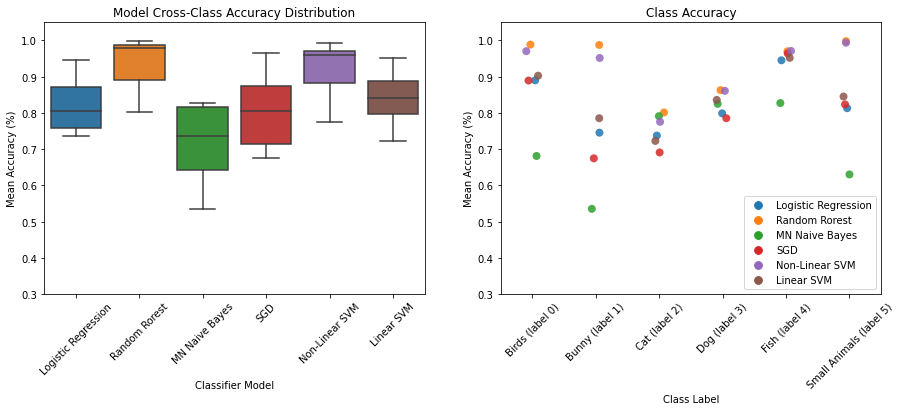

In [98]:
# Model comparison visualisation

# unpivot df for plotting
mod_unpiv= model_suite[1].melt(id_vars=['Resample Method'],var_name='Class Label',value_name='Accuracy')

# plot
fig, ax =plt.subplots(1,2,figsize=(15,5))

# model performance across classes
plt.subplot(1, 2, 1) # row 1, col 2 index 1
sns.boxplot(x='Resample Method',y='Accuracy',data=mod_unpiv)
plt.xticks(rotation=45)
plt.xlabel('Classifier Model')
plt.ylim(0.3,1.05)
plt.ylabel('Mean Accuracy (%)')
plt.title('Model Cross-Class Accuracy Distribution')

# model performance in Class
plt.subplot(1, 2, 2) # index 2
# replaced catplot to stripplot and removed kind='swarm'. Catplot does not work within subplot
sns.stripplot(x='Class Label',y='Accuracy',hue='Resample Method',palette = 'tab10',data=mod_unpiv,alpha=0.85 ,s=8)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.ylim(0.3,1.05)
plt.ylabel('Mean Accuracy (%)')
plt.title('Class Accuracy')

## Candidate Model Selection
Evaluation indicates that both Random Forest and Non-Linear (rbf kernel) SVM classifiers are the most performant and will be considered for the final model evaluation. These both achieve significantly greater evaluation metric scores in comparison to competing models. Accuracy increases +7.5% in comparison to the best competitor model, whilst F1 improves +10%. Furthermore, mean Accuracy distribution across individual classes indicates that both of these models minimise deviation well between classes. In addition, in-class accuracy indicates that boundaries between classes have been established, with leading classifier scores for each class. 

Across all models, minority class accuracy has improved in contrast to the baseline, suggesting that oversampling has been effective. However, a particular consideration for Random Forest and Non-Linear SVM is the very high accuracy scores for oversampled minority classes. This could be indicative of over-fitting to the training data. However, with limited training data available for use, this will have to be determined following testing upon unseen data. 



# Hyper-Parameterisation Pipeline
Parameter optimisation can further develop the predictive capabilities of these two candidate models. This process iterates through different classifier hyper-parameters, the object being to identify optimal combinations, which minimises training loss and enhance the model’s ability to generalise class data patterns and determine decision boundaries; solving this PoC’s specific classification problem. For the purposes of this PoC, accuracy will be the target metric, with each classifier learning how to maximise the classification rate within cross-validation of the training data (Claesen and De Moor, 2015). 

Exhaustive Grid Search (Pedregosa et al., 2011) is the typical process used, systematically comparing each parameter combination specified within the parameter grid. Whilst thorough, there are significant performance drawbacks, especially as the number of parameter combinations increases, limiting feasibility. This was a particular concern within the PoC given the search space not only included classifier parameters, but using a pipeline, also sought to optimise features (TF-IDF), and reduce highly dimensional data (Bengfort, Bilbro and Ojeda, 2018; Lee, 2020), which enhanced classifier performance. With 700 parameter combinations (SVM) and intensive pipeline processes, each requiring processing for the 3,500 fits occurring within the 5-fold cross validation. The limited computational resources available to this PoC would be unsuitable to perform this task. 

To mitigate these performance costs, Randomised Search was used, limiting total fits per fold to 10 randomly selected parameter combinations. Whilst, not exhaustive, Bergstra and Bengio (2012) found that performance was more effective at reaching equal performance to grid search, in some cases even out-performing, especially in cases of low effective parameter dimensionality. Furthermore, accelerated fit times enabled further search iteration to manually fine-tune parameter distributions to quickly identify optimal parameters.


In [ ]:
# Random Forest Parameterisation

# Pipeline
model = make_pipeline(TfidfVectorizer(),
                              SMOTE(),
                              TruncatedSVD(),
                              MinMaxScaler(),
                              RandomForestClassifier()
                              )

imba_param = {'tfidfvectorizer__ngram_range':[(1,1),(1,2)], #unigrams or unigrams and bigrams
              'tfidfvectorizer__max_df':[0.95,1.0], # max documents to include corpus. where in 95% of texts or word in 100%
              'tfidfvectorizer__min_df':[1,3,5], # min docs a word has to be in
              'smote__sampling_strategy':['not majority'], # based on previous iteration
              'smote__random_state':[10],
              'truncatedsvd__n_components':[100], # 100 based on previous iteration
              'randomforestclassifier__max_depth':[10,100],
              'randomforestclassifier__n_estimators':[50,100,1000],
              'randomforestclassifier__min_samples_leaf':[1,2,4],
              'randomforestclassifier__max_features':['auto','sqrt'],
              'randomforestclassifier__random_state':[10]
              'randomforestclassifier__n_jobs':[-1]
              }

# fitting pipeline
model.fit(clean_review_train,y_train)


# 5 fold randomised search (performance benefits over grid search)
rdgrid = RandomizedSearchCV(estimator=model,param_distributions=imba_param,cv=5,scoring='accuracy',verbose=1)

bst_rf_rdCV = rdgrid.fit(clean_review_train,y_train)

# search outcomes (Completed on alternative Google Colab TPU)
print(bst_rf_rdCV.best_score_)
print(bst_rf_rdCV.best_params_) # if running on powerful machine, use the best_params_ attribute directly as fitted model
bst_rf_rdCV.cv_results_

# best params (Google Colab TPU): ngram(1,1),min_df(1), max_df(0.95),n_estimators(1000),min_samples_leaf(1), max_features(auto),max_depth(100)



In [9]:
# Non-Linear SVM Parameterisation

# Pipeline
model = make_pipeline(TfidfVectorizer(),
                        SMOTE(),
                        TruncatedSVD(),
                        MinMaxScaler(),
                        SVC()
                     )


parameters = {'tfidfvectorizer__min_df':[1,3,5],
              'tfidfvectorizer__ngram_range':[(1,1),(1,2)],
              'tfidfvectorizer__max_df':[0.95,1.0],
              'smote__sampling_strategy':['not majority'],
              'truncatedsvd__n_components':[100], # 100 components determined in earlier process
              'svc__C':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10],
              'svc__gamma':[0.1,1,2,3,4,5,10],
              'svc__kernel':['rbf'], # non-linear SVM determined during initial model selection
              'svc__random_state':[10],
              'svc__max_iter':[10000] # control processing time
              }

model.fit(clean_review_train,y_train)  

# randomizedSearchCV performance benefits over GridSearch
rdgrid = RandomizedSearchCV(estimator=model,param_distributions=parameters,scoring='accuracy',cv=5,verbose=1)


# search outcomes (Completed externally on Google Colab TPU)
bst_svm_rdCV = rdgrid.fit(clean_review_train,y_train) 
print(bst_svm_rdCV.best_params_) # if running on powerful machine, use the best_params_ attribute directly as fitted model
print(bst_svm_rdCV.best_score_)
bst_svm_rdCV.cv_results_


# best params (Google Colab TPU): ngram(1,2),min_df(3), max_df(0.95),kernel(RBF),gamma(4),C(1)




In [9]:
# best models

best_rf = RandomForestClassifier(random_state = 10,
                                 n_estimators=1000,
                                 min_samples_leaf=1,
                                 max_features='auto',
                                 max_depth=100)


best_svm = SVC(kernel='rbf',
               random_state=10,
               gamma=4,
               C=1,
               max_iter=10000,
               probability=True) # param needed for precision-recall curve

## ADD UPDATE Parameter Tuning Summary
add text and clean up segment

- dif ngrams selected by model
- multiple iterations to finetune parameter grid
- length of time taken - lots!

# ADD UPDATE Model Evaluation (Testing Data)
Explan how I will do evaluation:
- Confusion Matrix - and why normalised (as Recall (True)) - to show True Positives as Proportion of total True Labels (True pos / (True pos + False Negatives)
- Precision Recall Curve (and why not using ROC curve due to imbalanced initial status of data)

Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

ROC AUC can be over-optimistic 
 see this link
 https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

## Baseline) Naive Bayes Baseline: Non-tuned

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       282
           1       1.00      0.01      0.01       152
           2       0.79      0.66      0.72      4932
           3       0.75      0.94      0.84      7467
           4       0.99      0.45      0.62       958
           5       0.00      0.00      0.00        91

    accuracy                           0.77     13882
   macro avg       0.76      0.35      0.37     13882
weighted avg       0.79      0.77      0.75     13882



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'Birds'),
  Text(1.5, 0, 'Bunny'),
  Text(2.5, 0, 'Cat'),
  Text(3.5, 0, 'Dog'),
  Text(4.5, 0, 'Fish'),
  Text(5.5, 0, 'Small Animals')])

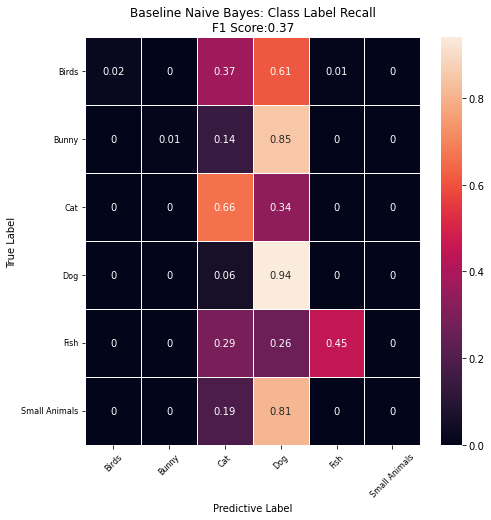

In [353]:
# nb confusion matrix
# create

X_train_clean
X_test_clean
y_train
y_test

nb_fit = NB.fit(X_train_clean,y_train)
nb_pred = nb_fit.predict(X_test_clean)


nb_cm = confusion_matrix(y_test,nb_pred,normalize='true').round(2)
nb_cm = pd.DataFrame(nb_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

# classification report
print(classification_report(y_test,nb_pred))

#confusion matrix (normalised for pred accuracy)
# baseline NB
fig, ax =plt.subplots(1,1,figsize=(7.5,7.5))

#f1
nb_f = f1_score(y_test,nb_pred,average='macro').round(2)


#confusion matrix (normalised for pred accuracy)
plt.subplot(1, 1, 1) # plot 1
sns.heatmap(nb_cm,annot=True,fmt='g',linewidth=0.5) 
plt.title('Baseline Naive Bayes: Class Label Recall\nF1 Score:{0:.2f}'.format(nb_f))
plt.xlabel('Predictive Label', fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.yticks(rotation=0,fontsize=8)
plt.xticks(rotation=45,fontsize=8)




## Candidate 1) Random Forest: Tuned

In [28]:
# best tfidf parameters

# random forest

# best params for rf

# tfidf
tf_idf_clean_1 = TfidfVectorizer(ngram_range = (1,1),min_df=1,max_df=0.95)

# features to use for training set
X_train_rf_params = tf_idf_clean_1.fit_transform(clean_review_train)
X_test_rf_params = tf_idf_clean_1.transform(clean_review_test)

# applying training corpus to test data
#tf_idf_clean_2 = TfidfVectorizer(vocabulary=tf_idf_clean_1.vocabulary_)

#X_test_clean = tf_idf_clean_2.fit_transform(clean_review_test)

# 11076 features
print('TFIDF X train and test: ',X_train_rf_params.shape, X_test_rf_params.shape)

# oversample training with SMOTE
X_train_rf_smt, y_train_smt = smt.fit_resample(X_train_rf_params,y_train)
print('SMOTE X and Y train: ',X_train_rf_smt.shape,y_train_smt.shape)


# dimension reduction
# feature reduction of data to 100 for train and test
svd = TruncatedSVD(n_components=100, random_state=10,n_iter=10)
svd.fit_transform(X_train_rf_smt) # fit to train

X_train_rf = svd.fit_transform(X_train_rf_smt)
X_test_rf = svd.transform(X_test_rf_params) # use train parameters on test (test remains unseen)
scaler = MinMaxScaler() # need to scale for NB use (cannot be negative)
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf) #use train parameters on test (test remains unseen)

print('Dim Reduction X train and test: ',X_train_rf.shape, X_test_rf.shape)


TFIDF X train and test:  (55528, 27164) (13882, 27164)
SMOTE X and Y train:  (179196, 27164) (179196,)
Dim Reduction X train and test:  (179196, 100) (13882, 100)


In [29]:
# binarize multiclass labels for use in prec-recall curve (one-hot encoding)
classes = [0,1,2,3,4,5]
n_classes = 6
class_name = {0:'Birds',1:'Bunnny',2:'Cat',3:'Dog',4:'Fish',5:'Small Animals'}

# train and test data
y_binary_train = label_binarize(y_train_smt,classes=classes)
y_binary_test = label_binarize(y_test,classes=classes)

In [30]:
# Random Forest Model evaluation on Test Data

rf_fit = best_rf.fit(X_train_rf,y_train_smt)
rf_ypred = rf_fit.predict(X_test_rf)

# classification report
print(classification_report(y_test,rf_ypred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       282
           1       0.52      0.66      0.58       152
           2       0.81      0.73      0.77      4932
           3       0.83      0.88      0.85      7467
           4       0.82      0.86      0.84       958
           5       0.62      0.40      0.48        91

    accuracy                           0.82     13882
   macro avg       0.73      0.72      0.72     13882
weighted avg       0.82      0.82      0.82     13882



In [342]:
#f1
rf_f = f1_score(y_test,rf_ypred,average='macro').round(2)
print('Random Forest F1 Score: ',rf_f)
# rf confusion matrix
rf_cm = confusion_matrix(y_test,rf_ypred,normalize='pred').round(2)
rf_cm = pd.DataFrame(rf_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])



Random Forest F1 Score:  0.72


In [31]:
X_train_rf.shape, y_binary_train.shape

((179196, 100), (179196, 6))

In [34]:
# fit and predict RF
rf_classifier = OneVsRestClassifier(best_rf) # takes long time, refrain from rerunning (~5hrs)
rf_score = rf_classifier.fit(X_train_rf, y_binary_train).predict_proba(X_test_rf) # predict_proba for binary classification

In [203]:
#RF: Visualise evaluation

# CM
rf_cm = confusion_matrix(y_test,rf_ypred,normalize='true').round(2) # pred normalise = Correct/ total label predictions
rf_cm = pd.DataFrame(rf_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

# PR curve
precision = dict()
recall = dict()



## Candidate 2) Non-Linear SVM: Tuned

In [12]:
# best tfidf parameters

# non-linear svm

# best params for svm

# tfidf
tf_idf_clean_1 = TfidfVectorizer(ngram_range = (1,2),min_df=3,max_df=0.95) # 146459 features generated

# features to use for training set
X_train_svm_params = tf_idf_clean_1.fit_transform(clean_review_train)
X_test_svm_params = tf_idf_clean_1.transform(clean_review_test)


# 11076 features
print('TFIDF X train and test: ',X_train_svm_params.shape, X_test_svm_params.shape)

# oversample training with SMOTE
X_train_svm_smt, y_train_smt = smt.fit_resample(X_train_svm_params,y_train)
print('SMOTE X and Y train: ',X_train_svm_smt.shape,y_train_smt.shape)


# dimension reduction
# feature reduction of data to 100 for train and test
svd = TruncatedSVD(n_components=100, random_state=10,n_iter=10)
svd.fit_transform(X_train_svm_smt) # fit to train

X_train_svm = svd.fit_transform(X_train_svm_smt)
X_test_svm = svd.transform(X_test_svm_params) # use train parameters on test (test remains unseen)
scaler = MinMaxScaler() # need to scale for NB use (cannot be negative)
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm) #use train parameters on test (test remains unseen)

print('Dim Reduction X train and test: ',X_train_svm.shape, X_test_svm.shape)


TFIDF X train and test:  (55528, 146459) (13882, 146459)
SMOTE X and Y train:  (179196, 146459) (179196,)
Dim Reduction X train and test:  (179196, 100) (13882, 100)


In [13]:
# SVM evaluation on Test Data

start = time.time()
svm_fit = best_svm.fit(X_train_svm,y_train_smt)# refrain from rerunning - 6hrs
svm_ypred = svm_fit.predict(X_test_svm)
end = time.time()
fit_time = ((end-start)/60)/60 #hours
print('Fitting Time (hr): ',fit_time,'\n')
svm_cm = confusion_matrix(y_test,svm_ypred)
# print(svm_cm)

print(classification_report(y_test,svm_ypred))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Fitting Time (hr):  2.059123603304227 

              precision    recall  f1-score   support

           0       0.67      0.77      0.72       282
           1       0.53      0.61      0.57       152
           2       0.85      0.71      0.77      4932
           3       0.82      0.90      0.86      7467
           4       0.79      0.86      0.82       958
           5       0.54      0.32      0.40        91

    accuracy                           0.82     13882
   macro avg       0.70      0.70      0.69     13882
weighted avg       0.82      0.82      0.82     13882



In [344]:
#f1
svm_f = f1_score(y_test,svm_ypred,average='macro').round(2)
print('SVM F1 Score: ',svm_f)

# svm confusion matrix
svm_cm = confusion_matrix(y_test,svm_ypred,normalize='pred').round(2)
svm_cm = pd.DataFrame(svm_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

SVM F1 Score:  0.69


In [17]:
# fit and predict SVM - binary
start = time.time()
svm_classifier = OneVsRestClassifier(best_svm) # 
svm_score = svm_classifier.fit(X_train_svm, y_binary_train).predict_proba(X_test_svm)
end = time.time()
fit_time = end-start
print('Time to fit and predict: ',fit_time)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

Time to fit and predict:  49147.572525024414


In [201]:
#SVM: Visualise evaluation

# CM
svm_cm = confusion_matrix(y_test,svm_ypred,normalize='true').round(2) # pred normalise = Correct/ total label predictions
svm_cm = pd.DataFrame(svm_cm,
                     index = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'], 
                     columns = ['Birds','Bunny','Cat','Dog','Fish','Small Animals'])

# PR curve
precision_svm = dict()
recall_svm = dict()





Candidate Model Evaluation: 



Text(0.5, 1.0, 'Non-Linear SVM: Precision-Recall Curve')

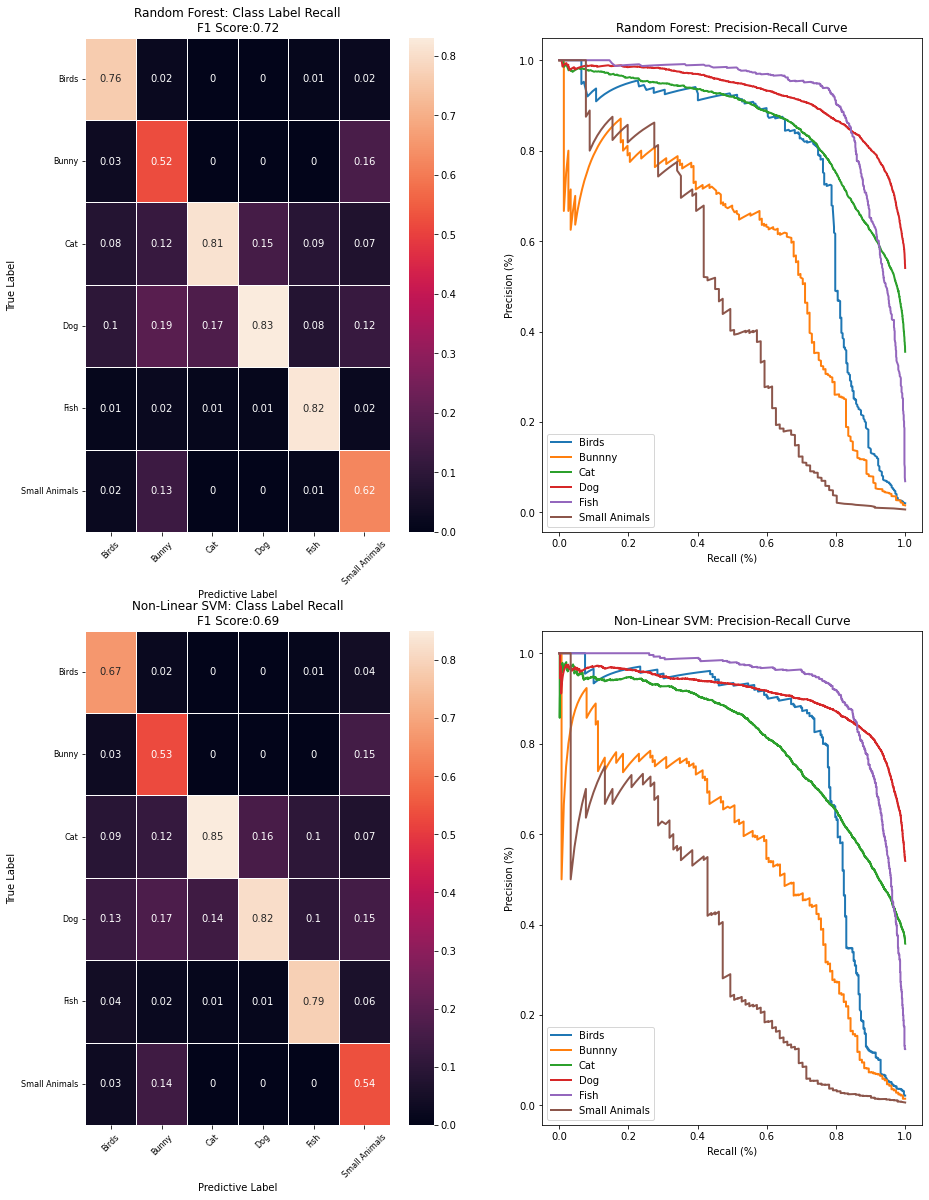

In [352]:
# Classifier Evaluation - Visualisation
# Confusion Matrix comparison (Normalised - True (Recall))
# Precision-Recal Curve


fig, ax =plt.subplots(2,2,figsize=(15,20))

print('\n\nCandidate Model Evaluation: \n')
# rf
plt.subplot(2, 2, 1) # plot 1
sns.heatmap(rf_cm,annot=True,fmt='g',linewidth=0.5) 
plt.title('Random Forest: Class Label Recall\nF1 Score:{0:.2f}'.format(rf_f))
plt.xlabel('Predictive Label', fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.yticks(rotation=0,fontsize=8)
plt.xticks(rotation=45,fontsize=8)


plt.subplot(2,2, 2) # plot 2
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_binary_test[:, i],
                                                        rf_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=class_name[i])
 
 
plt.xlabel('Recall (%)',fontsize=10)
plt.ylabel('Precision (%)',fontsize=10)
plt.legend(loc="best")
plt.title("Random Forest: Precision-Recall Curve")

# svm
plt.subplot(2,2,3) # plot 3
sns.heatmap(svm_cm,annot=True,fmt='g',linewidth=0.5) 
plt.title('Non-Linear SVM: Class Label Recall\nF1 Score:{0:.2f}'.format(svm_f))
plt.xlabel('Predictive Label', fontsize=10)
plt.ylabel('True Label',fontsize=10)
plt.yticks(rotation=0,fontsize=8)
plt.xticks(rotation=45,fontsize=8)

plt.subplot(2,2, 4) # plot 3
for i in range(n_classes):
    precision_svm[i], recall_svm[i], _ = precision_recall_curve(y_binary_test[:, i],
                                                        svm_score[:, i])
    plt.plot(recall_svm[i], precision_svm[i], lw=2, label=class_name[i])
 
 
plt.xlabel('Recall (%)',fontsize=10)
plt.ylabel('Precision (%)',fontsize=10)
plt.legend(loc="best")
plt.title('Non-Linear SVM: Precision-Recall Curve')


## Evaluation Summary
The two best performing, tuned candidate classifiers have been evaluated and compared against the initial baseline Naive Bayes to establish any potential benefits gained by processing and parameterisation within this PoC. Evaluation is based upon Classification reports and normalised (Recall) Confusion Matrices (CM). Precision-Recall Curve (PRC) further investigates candidate performance.

The baseline Naive Bayes classifier over-emphasises importance of majority classes. Significant class imbalances alongside lack of parameterisation train the baseline to not generalise well to non-majority class labels. This is particularly apparent in Classes with less than 1000 instances in the test data, with a maximum score of 2% Recall recorded by Birds class. Furthermore, the extremely positive Precision scores result from the enhanced likelihood of correct selection of majority classes, which the model has wrongly prioritised.


Both candidate classifiers (Random Forest and SVM) perform better than the initial baseline, with much more effective generalisation for minority class predictions. In particular, Fish Class accuracy improves significantly from 45% Recall (Baseline) to 86% for both candidate models. Processing and oversampling are clearly beneficial, but these candidates have been much more effective at training the model to recognise class boundaries; further supported by the unique habitat and therefore unique vocabulary of the class. In addition, both classifiers increase F1 scores in comparison to the baseline, indicating that both Precision and Recall improve. This is best illustrated in each respective CM. Minority Class True Positives become the majority prediction for each label, although some classes remain low scoring, such as Small Animals or Bunny. However, it should be noted that limitations in original source data limit class vocabularly, and because of this, class differentiation could be impaired. This is further compounded by natural overlap between the two classes. Bunny is a sub-class within the aggregated Small Animal class and unlike Fish, shares the same environment and pet niche as other Small Animal sub-classes. Lack of domain knowledge prevents additional relabelling due to limited understanding of Small Animal sub-classes. Recall (CM) in particular for Small Animals is affected, with 27% and 26% misclassification for Small Animals recorded respectively (RF and SVM). Random Forest however, is more effective at reducing total Small Animal misclassificlassification yielding an Accuracy score of 40% in contrast to SVM's 32%.

Confusion Matrix comparison indicates that Random Forest is a more effective predictor in most classes. This is represented by the greater total F1 score, of 72% in comparison to 69% achieved by SVM. Despite SVM scoring 2% greater in classification of Dog reviews, the significance of this result is limited due to the high scores recorded for both classifiers (88% and 90% respectively). This is supported by candidate PRC. Each Class label for Random Forest trends closer towards the upper-right 'perfect' score in comparison to SVM. Besides improvements to Small Animal and Bunny, Random Forest fruther improves Cat Precision.

Thorough Evaluation of both candidate classifiers indicates that despite fewer initial features pre-reduction (27,164 to 146,459 corpus entries) Random Forest is a more effective at generalising the training data to unseen data and making more accurate predictions for each Class Label as a result. This is fundamental due to the equal importance assigned to each label, despite the imbalanced nature of the original dataset limiting scope for those in the minority classes. Performance overall indicates that the Random Forest Classifier is the most effective candidate model and will be used on future review datasets to provide product classification as part of PoC scope.


# Conclusion and Reflection

add text about me working in process, learning curve, improvements etc.

Conclusion, reflection, future thoughts:

Tool choice:
-	Google colab has more powerful resources, but enforced time outs and disconnections are common
-	Issues with the parameter tuning of SVC, as hard to know where to start
-	Used RandomizedSearchCV to mitigate longer processing times of GridSearch due to crash likelihood of Google Colab, but as a result found harder to nail down best combos to start with,
-	Furthermore, this prevented taking predictions directly from created model so had to recreate steps manually – inefficient – could not use the randomizedSearch.predict output for best_params_ as a result.
-	Future – do with more powerful dedicated resources for processing
-	Gained experience of general ‘preferred’ parameters for SVM and RF. 
-	Pipelines v effective, in future, run pipeline through likely 3 models at start instead of manual iteration ‘exploration’. Although in this project it was necessary for understanding
-	Good experience in understanding ‘what a computer can handle before crashing’. What is ideal vs what is practical.
-	In future, although I used different resampling techniques. Combine different techniques together, e.g. undersample and then SMOTE. 29k rows per class is probably overkill.
-	Thoughts on the label of data
o	E.g. need more domain knowledge on small animals vs bunny. What animals make up small animals, are most of those rabbits? High fn rate for bunny when true = small animals

- more powerful resources - put everything into make_pipeline including various reductions and different resampling strategies

Second. Let’s face it. Hyperparameter tuning is time-consuming and computationally expensive. It takes a lot of time to iterate different combination of hyperparameters to achieve a minor improvement. Even worse, each iteration requires heavy resources if you have a massive amount of data and complex model. In business context, time is money. And if the effort and time needed in the search for optimum hyperparameters don’t justify the final ROI (Money!), chances are hyperparameter tuning is not needed at all if your model is good enough for deployment given a set of data with great features.
https://towardsdatascience.com/why-you-should-do-feature-engineering-first-hyperparameter-tuning-second-as-a-data-scientist-334be5eb276c
